# Plotting a map with cartopy

Objectives: 
> - plot a shaded relief (hillshade) from a geotif
> - add shapefile outlines
> - plot data (here elevation changes)

Load useful packages and define working directory

In [1]:
import matplotlib as mpl
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from osgeo import osr, gdal, gdalconst
gdal.UseExceptions()
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
path = 'C:\\Users\\brunbarf\\Data\\05_recherche\\Fedchenko\\'


Load shapefiles

In [2]:
shpname = path+'shp_Fedchenko\\RGI60_around_Fedchenko_UTM.shp'
glacier_outlines = shpreader.Reader(shpname)

ICESat_shp = path + 'ICESat_data/ICESat_clean/ICESat_conv_elli_ok_with_Pl_22_09_2019_from_buffer.shp'
reader_ICESat = shpreader.Reader(ICESat_shp)

Load hillshade

In [3]:
ds = gdal.Open(path+'Pleiades_Sept_22/merged_realigned_SGM/Hillshade_Fedchenko_merged_2019-09-22_to_23_DEM_4m_realigned_X_Y.tif')
gt = ds.GetGeoTransform()
proj = ds.GetProjection()
nc = ds.RasterXSize
nl = ds.RasterYSize
hillshade = ds.GetRasterBand(1).ReadAsArray()
ds = None
hillshade = hillshade.astype(float)
hillshade[hillshade==0] = np.nan

Convert projection from gdal to catopy

In [4]:
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)
projcs = inproj.GetAuthorityCode('PROJCS')
projection = ccrs.epsg(projcs)

Define the extent on which you want to plot the map

In [5]:
# option 1 = automatic extent (defined from the geotif)
xmin=gt[0]
xmax=gt[0] + nc * gt[1]
ymin=gt[3] + nl * gt[5]
ymax=gt[3]

In [11]:
# option 2 = custom extent
xmin=260000
xmax=275000
ymin=gt[3] + nl * gt[5]
ymax=gt[3]

Create figure instance and plot hillshade

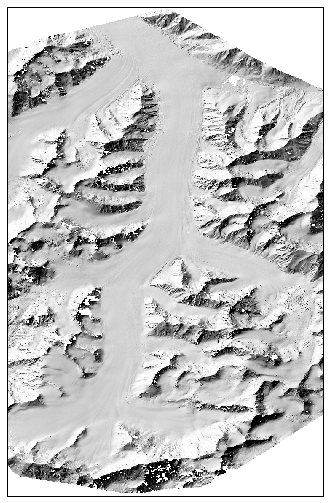

In [12]:
subplot_kw = dict(projection=ccrs.PlateCarree())
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=subplot_kw)

ax.set_extent([xmin, xmax, ymin,ymax], crs=projection)

extent = (gt[0], gt[0] + nc * gt[1],
          gt[3] + nl * gt[5], gt[3])


img = ax.imshow(hillshade,transform = ccrs.epsg(projcs), extent=extent,
                cmap = cm.Greys_r,
                origin='upper')

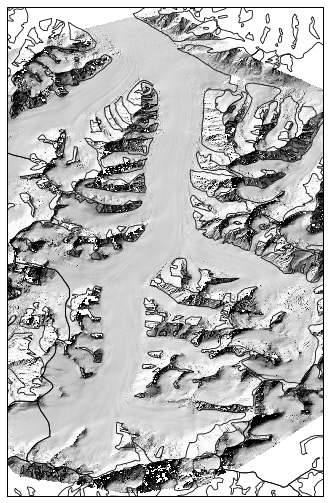

In [13]:
for line in glacier_outlines.records():
    ax.add_geometries([line.geometry], ccrs.epsg(projcs) ,facecolor='none' 
            , edgecolor='black',linewidth=0.8, zorder=2)
fig

Define colormap and plot the data

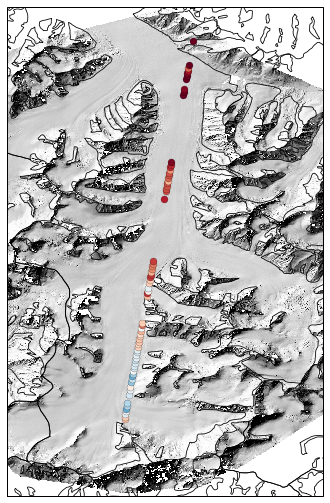

In [14]:
vmin = -10
vmax = 10

cmap = mpl.cm.get_cmap('RdBu')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
   
for ICESat_point in reader_ICESat.records():
    dh = ICESat_point.attributes['Pl_mean_IC']
    if ICESat_point.attributes['DEM0919std'] < 2:
        ax.plot(ICESat_point.geometry.x,
                ICESat_point.geometry.y,
                'o',
               markeredgecolor = 'k',
               markerfacecolor = cmap(norm(dh)),
               ms = 7,
               mew = 0.2,
               transform= ccrs.epsg(projcs),
               zorder = 10
                )
fig

Add a colorbar

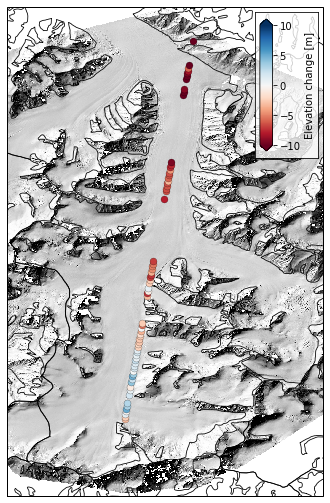

In [15]:
cbbox = inset_axes(ax, '20%', '30%', loc = 'upper right')
cbbox.set_xticks([]) 
cbbox.set_yticks([]) 
cbbox.set_facecolor([1,1,1,0.8])
ax2 = inset_axes(cbbox, '20%', '90%', loc = 6)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                extend = 'both',
                                orientation='vertical')
cb1.set_label('Elevation change [m]')
fig

Add coordinates

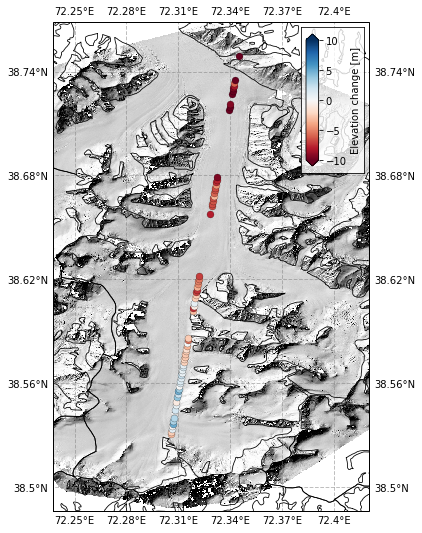

In [16]:
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
fig